In [340]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import mplcyberpunk
import tqdm
#from functions import nth_derivative

In [341]:
plt.style.use('cyberpunk')
# mplcyberpunk.make_lines_glow()

In [342]:
#real solutions

def Omegas(Y,t,gamma_r,gamma_m,gamma_l):
  Or,Om,Ol=Y
  gr,gm,gl = gamma_r,gamma_m,gamma_l
  #queremos el arreglo [y,F]
  #y=dx
  pi=gr*Or + gl*Ol + gm*Om

  return [3*(pi-gr)*Or,3*(pi-gm)*Om ,3*(pi-gl)*Ol]

# #Condiciones del sistema:
# y0=[0,1] #[x0,y0]
# delta,omega = 0.8,5 #parametros libres
# t = np.linspace(0, 10, 100) #tiempo

#la función sol del sistema
def sol_Omegas(y0, N, gamma_r,gamma_m,gamma_l):
   return odeint(Omegas, y0, N, args=(gamma_r,gamma_m,gamma_l))

In [343]:
N=np.linspace(0,-12,30)
O=sol_Omegas([0.0005,0.3,0.7],N,4.0/3.0,1.0,0.0)

In [344]:
# plt.plot(N,O[:,0])
# plt.plot(N,O[:,1])
# plt.plot(N,O[:,2])
# mplcyberpunk.make_lines_glow()

---

In [345]:
def nth_derivative(net, x:torch.Tensor, j:int, i:int ,n:int) -> torch.Tensor:
    """
    Esta función está creada para regresar la n-derivada de la componente j de la
    función ann respecto de la variable i. 
    
    ann(x)=(ann_0(x), ann_1(x)...,ann_j(x)...).
    
    Con x=(x_0,x_1,...,x_i,...)
    
    x debe ser un tensor: torch.Size([n, m])

    Para el buen funcionamiento: net(x)[0].shape = torch.Size([1])
    """
    x.requires_grad=True
    # Initialize the gradient tensor to 1.0, as the 0th derivative is the function itself.
    ann=net(x)[:,j].view(-1,1)
    grad_tensor = torch.ones(ann.size(), dtype=torch.float32, requires_grad=True)
    for _ in range(n):
        Dann=torch.autograd.grad(ann, x, grad_outputs=grad_tensor, create_graph=True)[0][:,i]
        Dann=Dann.reshape(ann.shape)
        ann=Dann
    return ann

In [346]:
# Definición de la función F(t)
def F(t):
  """
  Función vectorial F(t) = (t^2, 2t).

  Args:
    t: Tensor de PyTorch que representa el tiempo.

  Returns:
    Tensor de PyTorch que representa la función F(t).
  """
  t_squared = torch.pow(t, 2)
  two_t = 2 * t
  return torch.stack((t_squared, two_t), dim=1)

# Ejemplo de uso
t = torch.linspace(0.0, 1.0, 100)
f_t = F(t)

In [347]:
F(torch.tensor([3]))

tensor([[9, 6]])

In [348]:
nth_derivative(F,torch.tensor([[3.0]]), 1, 0,1)

tensor([[2.]], grad_fn=<ViewBackward0>)

Lets solve the ODE system:

\begin{align} 
x' =& 2x + y \\
y' =& -x + 3y
\end{align}

with $x(0) = 1$, $y(0) = 2$

\begin{align} 
x(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t} \\
y(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t}
\end{align}

## System of Ordinary Differential Equations
A number of coupled differential equations form a system of equations. Let $t \in \mathcal{R}$ 
be the independent variable and $$\bar{x}(t) : \mathcal{R}\longrightarrow \mathcal{R}^m$$
be a function of $t$. A system of ordinary differential equations of order $n$ takes the form:

$$F(t, \vec{x}, \frac{d\vec{x}}{dt}, \frac{d^2\vec{x}}{dt^2}, \ldots, \frac{d^n\vec{x}}{dt^n}) = \vec{0},
$$

\\


\\


$$
\begin{split}\begin{pmatrix}
f_0(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
f_1(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n}) \\
\vdots \\
f_{m-1}(t, \vec{x}, \displaystyle\frac{d\vec{x}}{dt}, \displaystyle\frac{d^2\vec{x}}{dt^2}, \ldots, \displaystyle\frac{d^n\vec{x}}{dt^n})
\end{pmatrix}
=
\begin{pmatrix}
0 \\
0 \\
\vdots \\
0
\end{pmatrix}\end{split}
$$

\begin{equation}

    \Omega_i' = 3(\Pi - \gamma_i)\Omega_i,
\end{equation}

con $\Pi = \sum_i \gamma_i \Omega_i$

$\Omega_r, \gamma_r = 4/3$

$\Omega_m, \gamma_m = 1$

$\Omega_\Lambda, \gamma_\Lambda = 0$



In [349]:
nodos=35
ANN = nn.Sequential(nn.Linear(1, nodos), nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    #nn.Tanh(), nn.Linear(nodos,nodos),
                    # nn.Tanh(), nn.Linear(nodos,nodos),
                    nn.Tanh(),nn.Linear(nodos,3))
print(ANN)

Sequential(
  (0): Linear(in_features=1, out_features=35, bias=True)
  (1): Tanh()
  (2): Linear(in_features=35, out_features=35, bias=True)
  (3): Tanh()
  (4): Linear(in_features=35, out_features=3, bias=True)
)


In [350]:
#The domain and the batch for the training
ti=-12.0
tf=0.0

t=torch.linspace(ti,tf,500).view(-1,1)

In [351]:
#t.cuda()

In [352]:
t.shape

torch.Size([500, 1])

In [353]:
# #reparam of the solution to meet the initial conditions
# init_conditions=torch.tensor([[0.0005,0.3,0.7]])

# def Param(t,x0=init_conditions,net=ANN):
#     #out = net(T)
#     #b=1-torch.exp(ti-T[:,0])
#     #return torch.reshape(T[:,1],out.size()) + b*out
#     #return T[:,1].view(-1,1) + a.view(-1,1) +b.view(-1,1)**2 * out
#     return x0 + (1.0-torch.exp(t))*net(t)
#     #return x0 + b.view(-1,1) * out}

\begin{align} 
x' =& 2x + y \\
y' =& -x + 3y
\end{align}

\begin{equation}

    \Omega_i' = 3(\Pi - \gamma_i)\Omega_i,
\end{equation}

con $\Pi = \sum_i \gamma_i \Omega_i$

$\Omega_r, \gamma_r = 4/3$

$\Omega_m, \gamma_m = 1$

$\Omega_\Lambda, \gamma_\Lambda = 0$



In [354]:
g_r = 4.0/3.0
g_m = 1.0
g_l = 0.0

def cost(t):
    t0=torch.tensor([0.0], requires_grad=True)
    t.requires_grad=True

    Or=ANN(t)[:,0].view(-1,1)
    Om=ANN(t)[:,1].view(-1,1)
    Ol=ANN(t)[:,2].view(-1,1)

    D_Or = nth_derivative(ANN,t, 0, 0,1)
    D_Om = nth_derivative(ANN,t, 1, 0,1)
    D_Ol = nth_derivative(ANN,t, 2, 0,1)

    pi = g_l*Ol + g_r*Or + g_m*Om

    a=torch.mean((D_Ol - 3*(pi - g_l)*Ol)**2)
    b=torch.mean((D_Or - 3*(pi - g_r)*Or )**2)
    c=torch.mean((D_Om - 3*(pi - g_m)*Om )**2)

    # a=torch.linalg.norm(D_Ol - 3*(pi - g_l)*Ol )**2
    # b=torch.linalg.norm(D_Or - 3*(pi - g_r)*Or )**2
    # c=torch.linalg.norm(D_Om - 3*(pi - g_m)*Om )**2

    x0 = torch.abs(ANN(t0) - torch.tensor([0.0005,0.3,0.7]))
    
    return  a + b + c + torch.linalg.norm(x0)**2

In [355]:
# t0=torch.tensor([[0.0]], requires_grad=True)
# t.requires_grad=True

# Or=ANN(t)[:,0].view(-1,1)
# Om=ANN(t)[:,1].view(-1,1)
# Ol=ANN(t)[:,2].view(-1,1)

# D_Or = nth_derivative(ANN,t, 0, 0,1)
# D_Om = nth_derivative(ANN,t, 1, 0,1)
# D_Ol = nth_derivative(ANN,t, 2, 0,1)

# # pi = g_l*Ol + g_r*Or + g_m*Om

# # # a=torch.mean((D_Ol - 3*(pi - g_l)*Ol )**2)
# # # b=torch.mean((D_Or - 3*(pi - g_r)*Or )**2)
# # # c=torch.mean((D_Om - 3*(pi - g_m)*Om )**2)

# # a=torch.linalg.norm(D_Ol - 3*(pi - g_l)*Ol )**2
# # b=torch.linalg.norm(D_Or - 3*(pi - g_r)*Or )**2
# # c=torch.linalg.norm(D_Om - 3*(pi - g_m)*Om )**2

# # x0 = ANN(t0) - torch.tensor([[0.0005,0.3,0.7]])

# # return  a + b + c + torch.mean(x0**2) 

In [356]:
D_Ol.shape==Ol.shape==t.shape

False

In [357]:
# x0 = 0.0
# y0 = 0.0

# def cost(t):
#     t0=torch.tensor([[0.0]], requires_grad=True)
#     t.requires_grad=True

#     x=ANN(t)[:,0].view(-1,1)
#     y=ANN(t)[:,1].view(-1,1)
#     #Ol=ANN(t)[:,2].view(-1,1)

#     Dx = nth_derivative(ANN,t, 0, 0,1)
#     Dy = nth_derivative(ANN,t, 1, 0,1)
#     # D_Ol = nth_derivative(ANN,t, 2, 0,1)

#     #pi = g_l*Ol + g_r*Or + g_m*Om

#     a=torch.mean((Dx - torch.sin(y))**2)
#     b=torch.mean((Dy - 4.0)**2)
#     #c=torch.mean((D_Om - 3*(pi - g_m)*Om )**2)

#     # a=torch.linalg.norm(D_Ol - 3*(pi - g_l)*Ol )**2
#     # b=torch.linalg.norm(D_Or - 3*(pi - g_r)*Or )**2
#     # c=torch.linalg.norm(D_Om - 3*(pi - g_m)*Om )**2

#     condiciones = ANN(t0) - torch.tensor([x0, y0])
    
#     return  a + b + torch.mean((condiciones)**2)

In [372]:
cost(t)

tensor(6.0979e-06, grad_fn=<AddBackward0>)

In [366]:
learning_rate=0.01
epocas=3000


optimizer = torch.optim.Adam(ANN.parameters(), lr=learning_rate)

In [367]:
t.cuda();

Training: 100%|███████████████████████████████████| 3000/3000 [00:30<00:00, 98.26it/s, loss=6.11e-6]


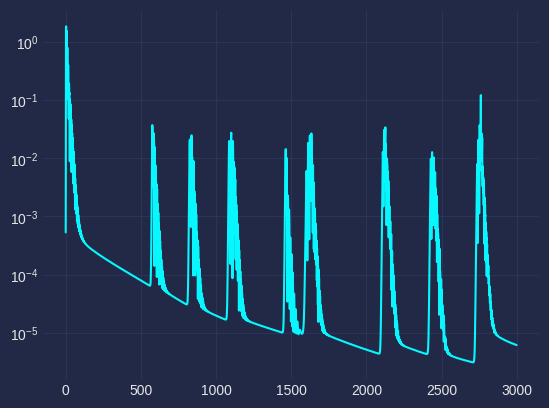

In [368]:
#loop de entrenamiendo 
pbar = tqdm.tqdm(range(epocas), desc="Training",  colour='cyan', ncols=100)

errores=[]
for i in pbar:
    l=cost(t) #coste
    #l=torch.nn.MSELoss(Param(T))
    l.backward() #gradiente
    optimizer.step() #se actualizan los parámetros
    optimizer.zero_grad() #vacíamos el gradiente
    #print('época=%.2f , loss=%.2f'%(i,l))
    errores.append(float(l))
    #tqdm.set_description('época: %d , loss: %.2f' % (i, l.item()))
    pbar.set_postfix({'loss': l.item()})
    #pbar.set_refresh(50)
    #tqdm.set_description("Training")
    #print('época=%.2f , loss=%.2f'%(i,l))

plt.plot(range(epocas),errores)
plt.yscale('log')

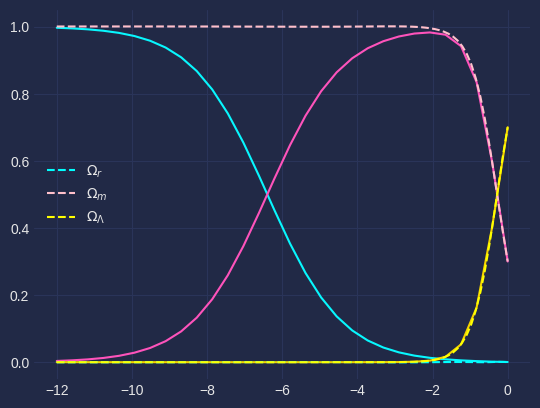

In [370]:
plt.plot(N,O[:,0])
plt.plot(N,O[:,1])
plt.plot(N,O[:,2])
# mplcyberpunk.make_lines_glow()
dom=torch.linspace(-12,0,100).view(-1,1)

# plt.plot(dom.detach(),dom.detach()**2, label='real')
#plt.plot(dom.detach(),-1/4*torch.cos(4*dom.detach())+0.25, label='real')

plt.plot(dom.detach(),ANN(dom).detach()[:,0],'--', label='$\Omega_r$', color='cyan')
plt.plot(dom.detach(),ANN(dom).detach()[:,1], '--',label='$\Omega_m$', color='pink')
plt.plot(dom.detach(),ANN(dom).detach()[:,2], '--',label='$\Omega_\Lambda$', color='yellow')
plt.legend()
#plt.plot(t.detach(),1/3 * torch.exp(t.detach()) + 2/3*torch.exp(4.0*t.detach()))
         
#y(t) =& \frac{1}{3}e^t + \frac{2}{3}e^{4t})
#mplcyberpunk.make_lines_glow()

In [371]:
ANN(torch.tensor([0.0]))

tensor([2.4937e-04, 3.0003e-01, 6.9999e-01], grad_fn=<ViewBackward0>)

# Parámetros del modelo
a = 1.0
b = 1.0
c = 1.0
d = 1.0

# Ecuaciones de Lotka-Volterra
def dxdt(x, y):
  return a * x - b * x * y

def dydt(x, y):
  return c * x * y - d * y

# Solución numérica de las ecuaciones
t = np.linspace(0,26, 100)
x = np.zeros(len(t))
y = np.zeros(len(t))

x[0] = 1.5
y[0] = 1.0

for i in range(1, len(t)):
  x[i] = x[i - 1] + dxdt(x[i - 1], y[i - 1]) * (t[i] - t[i - 1])
  y[i] = y[i - 1] + dydt(x[i - 1], y[i - 1]) * (t[i] - t[i - 1])

# Gráfica de las poblaciones
plt.plot(t, x, label="Presa")
plt.plot(t, y, label="Depredador")
plt.xlabel("Tiempo")
plt.ylabel("Población")
plt.legend()
plt.show()